## PHYS 105A:  Introduction to Scientific Computing

# Integration of Differential Equations II

Chi-kwan Chan

## Newton's Second Law is an ordinary differential equation (ODE)

* Given this is an introduction to computational physics course, we are interested in solving, e.g., Newton's equation:

  $m \frac{d^2 x}{dt^2} = f(x, t)$
  
* We can trivially cast this second order ODE into a system of two first order ODEs:
 
  $\frac{dx}{dt} = v$
  
  $\frac{dv}{dt} = \frac{1}{m}f(x, t)$
  
* Using "vector" notation, we define $X = [x, v]^t$ and $F = [v, f/m]^t$ so that
 
  $\frac{dX}{dt} = F(X, t)$.

## Euler's Method

* The ordinary differential equation (ODE) equations we want to solve takes the generic form:

  $\frac{dX}{dt} = F(X, t)$
  
  where $X$ may be a vector.
  
* Euler's Method allows us to step the solution forward:

  $X_{n+1} = X_n + f(X_n, t_n) \Delta t$
  
  where $\Delta t$ is the time step.

In [1]:
def forwardEuler(f, x, t, dt, n):
    T = np.array(t)
    X = np.array(x)
    for i in range(n):
        t += dt
        x += np.array(f(*x)) * dt
        T = np.append( T, t )
        X = np.vstack((X, x))
    return T, X

0.00039451207064656636


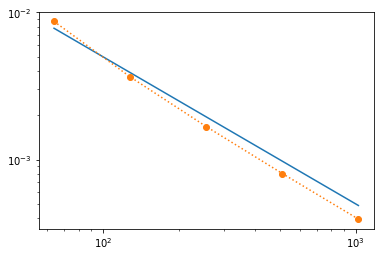

In [2]:
import numpy as np
from matplotlib import pyplot as plt

def f(theta, omega):
    return omega, -theta

def error(N=100):
    T, X = forwardEuler(f, (0, 0.01), 0, 10/N, N)
    Theta  = X[:,0]
    Thetap = 0.01 * np.sin(T)
    return np.max(abs(Theta - Thetap))

N = np.array([64, 128, 256, 512, 1024])
E = np.array([error(n) for n in N])

print(E[-1])

plt.loglog(N, 0.5/N)
plt.loglog(N, E, 'o:')

## Can We Improve the Method?

* Fordware Euler method is only first order accuate.

* Can we improve the convergent rate?  I.e., can we make the error reduce more rapidly as we use smaller steps?

* Take idea from our integrator lecture: mid Riemann sum converges faster than the left/right Reimann sum!

## A Mid-Point Method?

* Proposal:

    $X_{n+1} = X_n + f(X_{n+1/2}, t_{n+1/2}) \Delta t$
    
* However, this method does not work because $f_{n+1/2} \equiv f(X_{n+1/2}, t_{n+1/2})$ is **UNKNOWN** at step $n$.

* If the right hand side is independent of $X$, i.e., $dx/dt = f(t)$, this is an ODE and mid-point method works.  But this does not work for a generic ODE.

## A Simple Idea:

* It is good enough if we can find an approximated half-step solutoin $Y_{n+1/2}$.

* We may use forward Euler to obtain the half-step solution:

  $\tilde{X}_{n+1/2} = X_n + f(X_n, t_n) \Delta t$.
  
  $X_{n+1} = X_n + f(\tilde{X}_{n+1/2}, t_{n+1/2}) \Delta t$.
  
* This is called the second-order Runge-Kutta method.

![RK2 vs Euler](RK2_vs_Euler.png)

## Second-order Runge-Kutta Method

* To make the implementation easier, let's use the standard convention:

  $k_1 = \Delta t f(X_n, t_n)$
  
  $k_2 = \Delta t f(X_n + \frac{1}{2}k_1, t_n + \frac{1}{2}\Delta t)$
  
  $X_{n+1} = X_n + k_2 + \mathcal{O}(h^3)$

In [3]:
def RK2(f, x, t, dt, n):
    T = np.array(t)
    X = np.array(x)
    
    for i in range(n):
        k1 = dt * np.array(f(*(x         )))
        k2 = dt * np.array(f(*(x + 0.5*k1)))
        
        t += dt
        x += k2
        
        T = np.append( T, t)
        X = np.vstack((X, x))
        
    return T, X

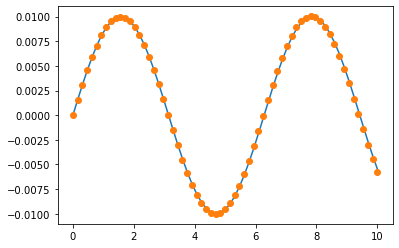

In [4]:
N=64

T, X = RK2(f, (0, 0.01), 0, 10/N, N)

plt.plot(T, 0.01*np.sin(T))
plt.plot(T, X[:,0], 'o')

1.5075036412163893e-06


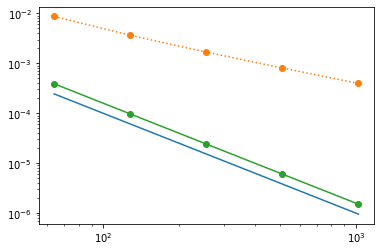

In [5]:
def error2(N=100):
    T, X = RK2(f, (0, 0.01), 0, 10/N, N)
    Theta  = X[:,0]
    Thetap = 0.01 * np.sin(T)
    return np.max(abs(Theta - Thetap))

N = np.array([64, 128, 256, 512, 1024])
E2 = np.array([error2(n) for n in N])

print(E2[-1])

plt.loglog(N, 1/N**2)
plt.loglog(N, E, 'o:')
plt.loglog(N, E2,'o-')

## Converge Rate

* As shown in the convergence plot, RK2 is second order.

* Using 1024 points in integration, although the computation cost almost double, the solution is ~ 250 times more accurate!

* Can we do even better than RK2?

## Observation and Proposal

* In RK2, the mid point value $X_n + \frac{1}{2}k_1$ is the simplest approximation computed using forward Euler:

  $k_1 = \Delta t f(X_n, t_n)$
  
  $k_2 = \Delta t f(X_n + \frac{1}{2}k_1, t_n + \frac{1}{2}\Delta t)$

* We may improve the estimate of the mid point value by using the forward Euler estimate:

  $k_3 = \Delta t f(X_n + \frac{1}{2}k_2, t_n + \frac{1}{2}\Delta t)$
  
* And the full step should be computed using this improved estimate:

  $k_4 = \Delta t f(X_n + k_3, t_n + \Delta t)$

## One last idea

* $k_1$, $k_2$, $k_3$, and $k_4$ are all estimate of how $X$ would change but with different error terms.

* A carefully constructed combination of them will allow us to cancel the error!

![RK4](RK4.png)

## Fourth-Order Runge-Kutta Method

* The classic 4th Runge-Kutta method:

  $k_1 = \Delta t f(X_n, t_n)$
  
  $k_2 = \Delta t f(X_n + \frac{1}{2}k_1, t_n + \frac{1}{2}\Delta t)$

  $k_3 = \Delta t f(X_n + \frac{1}{2}k_2, t_n + \frac{1}{2}\Delta t)$
  
  $k_4 = \Delta t f(X_n + k_3, t_n + \Delta t)$
    
  $X_{n+1} = Y_n + \frac{1}{6} k_1 + \frac{1}{3} k_2 + \frac{1}{3} k_3 + \frac{1}{6} k_4 + \mathcal{O}(\Delta t^5)$

In [6]:
def RK4(f, x, t, dt, n):
    T = np.array(t)
    X = np.array(x)
    
    for i in range(n):
        k1 = dt * np.array(f(*(x         )))
        k2 = dt * np.array(f(*(x + 0.5*k1)))
        k3 = dt * np.array(f(*(x + 0.5*k2)))
        k4 = dt * np.array(f(*(x +     k3)))
        
        t += dt
        x += k1/6 + k2/3 + k3/3 + k4/6
        
        T = np.append( T, t)
        X = np.vstack((X, x))
        
    return T, X

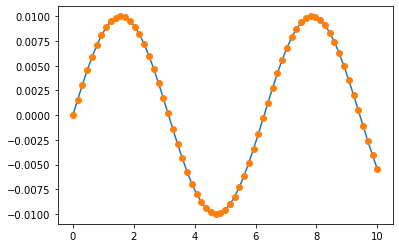

In [7]:
N=64

T, X = RK4(f, (0, 0.01), 0, 10/N, N)

plt.plot(T, 0.01*np.sin(T))
plt.plot(T, X[:,0], 'o')

7.189048618558291e-12


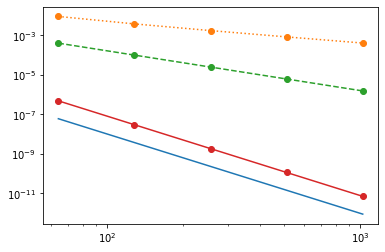

In [8]:
def error3(N=100):
    T, X = RK4(f, (0, 0.01), 0, 10/N, N)
    Theta  = X[:,0]
    Thetap = 0.01 * np.sin(T)
    return np.max(abs(Theta - Thetap))

N = np.array([64, 128, 256, 512, 1024])
E3 = np.array([error3(n) for n in N])

print(E3[-1])

plt.loglog(N, 1/N**4)
plt.loglog(N, E, 'o:')
plt.loglog(N, E2,'o--')
plt.loglog(N, E3,'o-')

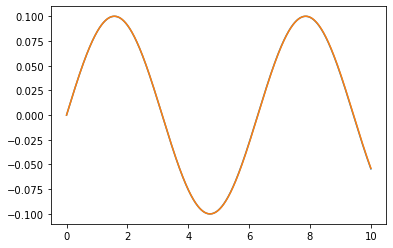

In [9]:
# With a high accurate ODE integrator, we can solve for the full gravity pendulum problem:

def f(theta, omega):
    return omega, -np.sin(theta)

N  = 1000
v0 = 0.1
T, X = RK4(f, (0, v0), 0, 10/N, N)

Theta = X[:,0]
Omega = X[:,1]

plt.plot(T, v0 * np.sin(T))
plt.plot(T, Theta)

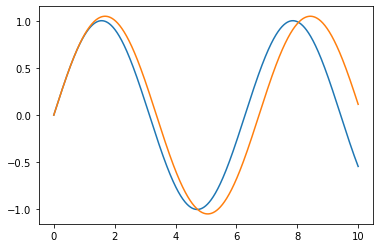

In [10]:
# When the initial velocity is no longer small, the simple harmonic oscillator approximation is no longer valid.

N  = 1000
v0 = 1
T, X = RK4(f, (0, v0), 0, 10/N, N)

Theta = X[:,0]
Omega = X[:,1]

plt.plot(T, v0 * np.sin(T))
plt.plot(T, Theta)

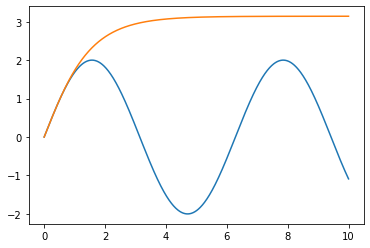

In [11]:
# When the initial velocity is large enough, the solution is not periodic.  What's going on?

N  = 1000
v0 = 2
T, X = RK4(f, (0, v0), 0, 10/N, N)

Theta = X[:,0]
Omega = X[:,1]

plt.plot(T, v0 * np.sin(T))
plt.plot(T, Theta)

## Comments

* Using some intuition we built in developing numerical integrators, we motivate the 4th-order Runge-Kutta method.

* The classical RK4 is a very *robust* and simple-to-implement numerical scheme.  It is a work horse work for integrating ODEs.

* When combined with more advanced methods like adaptive time stepping and dense output, RK4 can be used for many problems.

* However, there exist many other ODE integrators that may be bettter for specific problems.

* See, e.g., the [numerical recipe](http://s3.amazonaws.com/nrbook.com/book_C210.html) for reference.